In [1]:
import numpy as np
import polars as pl
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder


data = pl.read_csv("../data/raw_data/train.csv")


def add_state_avg_salary(data):
    """Add state average salary column based on job_state"""
    abbr_to_mean = {
        "NH": 97046, "MA": 94651, "OR": 94286, "PA": 93864, "NY": 93391,
        "MD": 92244, "WV": 90701, "TX": 89407, "VT": 89074, "NV": 88635,
        "CA": 87957, "ND": 87795, "VA": 86648, "ME": 86128, "WI": 85718,
        "DE": 85112, "NM": 84814, "KS": 84508, "OK": 84153, "WA": 83605,
        "AZ": 83199, "TN": 82354, "ID": 82316, "MS": 80873, "AR": 79907,
        "KY": 78545, "SC": 78256, "WY": 77540, "UT": 77455, "AL": 76867,
        "RI": 76628, "GA": 76574, "IL": 76205, "MN": 75504, "MT": 75309,
        "NJ": 74480, "IN": 73188, "IA": 72526, "CT": 72447, "NC": 71590,
        "CO": 71342, "MO": 70645, "FL": 70393, "OH": 68590, "HI": 67412,
        "LA": 67027, "AK": 65498, "NE": 65123, "SD": 62823, "MI": 61400
    }
    global_mean = sum(abbr_to_mean.values()) / len(abbr_to_mean)
    
    data = data.with_columns(
        pl.col("job_state")
        .cast(pl.Utf8)
        .replace(abbr_to_mean, default=global_mean)
        .fill_null(global_mean)
        .alias("state_avg_salary")
    ).drop("job_state")
    
    return data

def fill_missing_data(X):
    """Fill missing data using KNN imputation"""
    # Split columns into job_desc vs. everything else
    job_desc_cols = [c for c in X.columns if c.startswith("job_desc_")]
    other_cols = [c for c in X.columns if c not in job_desc_cols]

    # Fill non-job_desc columns with their means first
    other_filled = X.select(other_cols).with_columns([
        pl.col(c).fill_null(pl.col(c).mean()).alias(c)
        for c in other_cols
    ])

    # Convert to pandas for KNNImputer
    X_pd = X.to_pandas()

    # Fill non-job_desc columns with their means
    for col in other_cols:
        if X_pd[col].isna().any():
            X_pd[col] = X_pd[col].fillna(X_pd[col].mean())

    # Mask zeros in job_desc columns as nulls
    for col in job_desc_cols:
        X_pd.loc[X_pd[col] == 0, col] = np.nan

    # Apply KNN imputation
    imputer = KNNImputer(
        missing_values=np.nan,
        n_neighbors=5,
        weights="distance"
    )
    X_imputed = imputer.fit_transform(X_pd)

    # Create result DataFrame
    result = pl.DataFrame(X_imputed, schema=X.columns)

    return result


In [2]:
data = data.with_columns(
    pl.col("job_posted_date").str.strptime(pl.Date, format="%Y/%m"),
    pl.col("job_title").cast(pl.Categorical),
    pl.col("job_state").cast(pl.Categorical),
    pl.col("feature_1").cast(pl.Categorical),
    pl.col(pl.Boolean).cast(pl.Int32)
)


data = data.with_columns(
    pl.col("salary_category").cast(pl.Categorical),
)

# Define column groups
feature_cols = [f"feature_{i}" for i in range(1, 13)]
job_desc_cols = [f"job_desc_{i:03d}" for i in range(1, 301)]
extra_feature = ["state_avg_salary", "job_title", "months_since_ref", "month", "jd_norm"]

# Calculate reference date
ref = data["job_posted_date"].min()
ref_total = ref.year * 12 + ref.month - 1

# Add time-based features
data = data.with_columns([
    # Linear trend: months since ref
    (
        (pl.col("job_posted_date").dt.year() * 12 +
         pl.col("job_posted_date").dt.month() - 1)
        - ref_total
    ).alias("months_since_ref"),
    pl.col("job_posted_date").dt.month().alias("month"),
])

# Add job description norm feature
data = data.with_columns(
    np.sqrt(sum(pl.col(c) ** 2 for c in job_desc_cols)).alias("jd_norm")
)

# Add state average salary
data = add_state_avg_salary(data)

# Prepare features
total_features = feature_cols + job_desc_cols + extra_feature
X = data.select(total_features).to_dummies(
    columns=["job_title", "feature_1"]
)


Y = data["salary_category"]
le = LabelEncoder().fit(Y)
Y_encoded = le.transform(Y)



X = fill_missing_data(X)

C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_27576\481388174.py:29: DeprecationWarning: The `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
  .replace(abbr_to_mean, default=global_mean)


In [3]:
data

obs,job_title,job_posted_date,salary_category,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,job_desc_001,job_desc_002,job_desc_003,job_desc_004,job_desc_005,job_desc_006,job_desc_007,job_desc_008,job_desc_009,job_desc_010,job_desc_011,job_desc_012,job_desc_013,job_desc_014,job_desc_015,job_desc_016,job_desc_017,job_desc_018,job_desc_019,job_desc_020,job_desc_021,…,job_desc_268,job_desc_269,job_desc_270,job_desc_271,job_desc_272,job_desc_273,job_desc_274,job_desc_275,job_desc_276,job_desc_277,job_desc_278,job_desc_279,job_desc_280,job_desc_281,job_desc_282,job_desc_283,job_desc_284,job_desc_285,job_desc_286,job_desc_287,job_desc_288,job_desc_289,job_desc_290,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300,months_since_ref,month,jd_norm,state_avg_salary
i64,cat,date,cat,cat,f64,i32,i32,i32,i32,i32,i32,i32,f64,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i8,f64,f64
1,"""Others""",2024-07-01,"""High""","""A""",0.6429,0,0,1,1,1,0,0,60.0,1,0,0.193511,2.275482,-0.440363,-0.327473,0.058464,-0.154043,-0.393158,-0.367905,-0.703665,0.562969,0.058359,-0.632267,0.326872,-0.276131,0.098252,0.019475,0.105348,-0.411405,0.635027,-0.192049,3.849681,…,-0.167435,-0.342473,0.185418,-0.233041,-0.016037,0.602155,-0.511326,0.60238,-0.25441,-0.114025,0.08606,-0.012974,0.523685,-0.864781,0.084526,0.15464,0.283154,-0.848735,-0.108635,0.049179,0.210502,-0.53584,0.113221,-0.362079,-0.499308,-0.367894,-0.214881,0.01487,-0.271177,-0.113347,-0.587955,-0.919095,-0.20734,68,7,9.237861,93391.0
2,"""Job_Title_1""",2024-07-01,"""Low""","""A""",0.4678,0,0,0,1,1,1,0,60.0,1,1,0.100152,2.291134,-0.356041,-0.494735,0.038632,-0.356995,-0.63302,-0.444805,-0.252597,0.18721,0.261958,-0.734535,0.264041,-0.209023,0.144627,-0.182167,0.144194,-0.43669,0.405126,-0.240945,3.781854,…,-0.065834,-0.395344,0.04834,-0.198469,0.0261,0.390649,-0.484126,0.53313,-0.196634,-0.330162,0.200502,0.047225,0.263908,-0.817924,-0.069964,0.357457,0.323456,-0.977607,-0.034979,-0.053379,-0.02734,-0.511633,-0.105435,-0.300989,-0.415411,-0.341824,-0.319064,0.042322,-0.124755,0.023489,-0.893224,-0.823024,0.112364,68,7,9.02549,87957.0
3,"""Others""",2024-07-01,"""Low""","""A""",0.461,0,0,0,1,1,1,0,36.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,7,0.0,87957.0
4,"""Others""",2024-07-01,"""Low""","""A""",0.5064,0,0,0,1,1,1,0,72.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,7,0.0,87957.0
5,"""Others""",2024-07-01,"""Low""","""A""",0.464,0,0,0,1,1,0,0,48.0,1,1,0.406864,1.986625,-0.726046,-0.316294,0.062115,-0.451118,-0.659871,-0.451544,-0.505597,0.119204,-0.542267,-0.623306,0.048583,-0.103152,-0.007468,0.236105,0.20434,-0.280865,0.203199,-0.435184,3.603102,…,0.175365,-0.272249,-0.008637,-0.153464,-0.001045,0.295818,-0.174998,0.781811,-0.155236,-0.612957,0.254792,-0.063058,0.259242,-0.669112,0.142055,0.200105,0.227985,-0.829408,-0.361299,0.005694,-0.118158,-0.654845,-0.099771,-0.406159,-0.654657,-0.074398,-0.464479,0.081037,-0.136992,-0.27627,-0.696853,-0.601466,0.089939,68,7,9.06218,87957.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1276,"""Job_Title_21""",2024-06-01,"""High""","""A""",0.5391,0,0,0,1,0,0,0,null,1,0,0.247692,2.241664,-0.773778,-0.349046,-0.112922,-0.44366,-0.623765,-0.57448,-0.646541,0.056761,

In [4]:
le_jt = LabelEncoder().fit(data["job_title"])
a = le_jt.transform(data["job_title"])
a

array([27,  0, 27, ...,  1, 11,  0], shape=(1280,))

In [5]:
data["feature_7"].value_counts()

feature_7,count
i32,u32
0,740
1,540


In [6]:
data["feature_1"].value_counts()

feature_1,count
cat,u32
"""A""",1232
"""C""",6
"""D""",5
"""B""",36
"""E""",1


In [7]:
data["months_since_ref"].value_counts()

months_since_ref,count
i32,u32
58,24
54,7
37,2
47,4
64,29
…,…
63,24
41,5
43,1


In [8]:
data["feature_10"].value_counts()

feature_10,count
f64,u32
6.0,3
144.0,6
null,446
24.0,76
48.0,100
…,…
300.0,1
192.0,2
84.0,47


In [9]:
data["month"].value_counts()

month,count
i8,u32
9,25
12,32
7,611
5,70
4,49
…,…
2,46
6,156
8,166


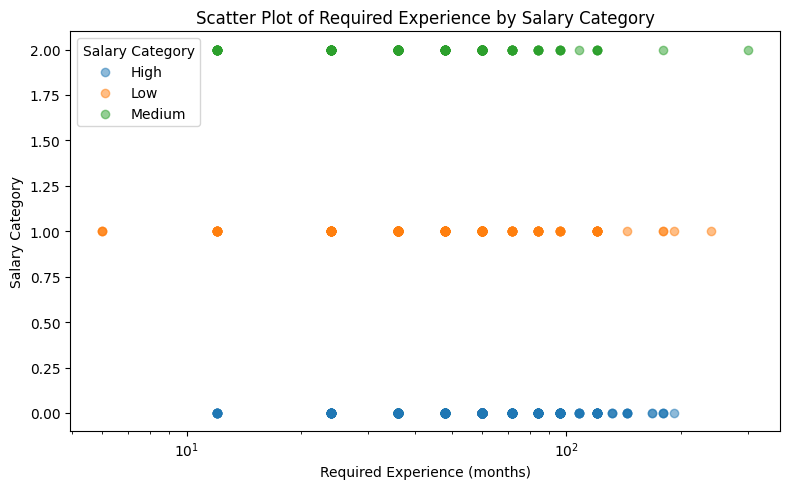

In [10]:
from matplotlib import pyplot as plt
import polars as pl

# Assume the experience column is named 'feature_10'; adjust if different
# Load your dataset as a Polars DataFrame
df_pd = data

# Fill nulls with 0
df_pd = df_pd.fill_null(0)

# Convert experience to integer months using with_columns
df_pd = df_pd.with_columns([
    pl.col("feature_10").cast(pl.Int32).alias("feature_10")
])

# Prepare data for scatter plot
categories = df_pd["salary_category"].unique().to_list()  # Get unique categories

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Loop through each category and plot the data
for i, category in enumerate(categories):
    category_data = df_pd.filter(pl.col("salary_category") == category)
    ax.scatter(category_data["feature_10"].to_list(), [i] * len(category_data), label=category, alpha=0.5)

# Set plot labels and title
ax.set_xlabel("Required Experience (months)")
ax.set_ylabel("Salary Category")
ax.set_title("Scatter Plot of Required Experience by Salary Category")

# Set logarithmic scale on the x-axis
ax.set_xscale('log')

# Add a legend
ax.legend(title="Salary Category")

# Display the plot
plt.tight_layout()
plt.show()


In [11]:
# Assume the experience column is named 'feature_10'; adjust if different
df_pd = data

# Fill nulls with 0
df_pd = df_pd.fill_null(0)

# Convert experience to integer months using with_columns
df_pd = df_pd.with_columns([
    pl.col("feature_10").cast(pl.Int32).alias("feature_10")
])

# Group by 'salary_category' and 'feature_10' and count the occurrences
count_df = df_pd.group_by(["salary_category", "feature_10"]).agg(
    pl.count().alias("count")
).sort("feature_10")

# Convert the result to a Pandas DataFrame for better visualization (optional)
count_df_pd = count_df.to_pandas()

# Print the result
print(count_df_pd)


   salary_category  feature_10  count
0           Medium           0    147
1             High           0    122
2              Low           0    177
3              Low           6      3
4             High          12      9
5           Medium          12     16
6              Low          12     13
7              Low          24     26
8             High          24     22
9           Medium          24     28
10            High          36     64
11          Medium          36     58
12             Low          36     60
13             Low          48     34
14            High          48     42
15          Medium          48     24
16          Medium          60     56
17            High          60    117
18             Low          60     56
19          Medium          72     11
20            High          72     32
21             Low          72     11
22             Low          84     12
23          Medium          84      7
24            High          84     28
25          

C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_27576\2843333211.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("count")
